Make sure you fill your name and NetID below:

In [ ]:
NAME = "Luan Minh Tran"
NET_ID = "lmt185"

---

---
# Linear Classifiers

In this notebook, you will build a linear image classifier from scratch in PyTorch. You will implement both the forward pass and backward pass of the linear classifier _without_ using PyTorch's autograd capabilities. It is largely adapted (with permission) from https://web.eecs.umich.edu/~justincj/teaching/eecs498/FA2019.

As in the first assignment, you will see code blocks that look like this:
```python
###############################################################################
# TODO: Create a variable x with value 3.7
###############################################################################
pass
# END OF YOUR CODE
```

You should replace the `pass` statement with your own code and leave the blocks intact, like this:
```python
###############################################################################
# TODO: Create a variable x with value 3.7
###############################################################################
x = 3.7
# END OF YOUR CODE
```

Also, please remember:
- Do not write or modify any code outside of code blocks
- Do not add or delete any cells from the notebook. You may add new cells to perform scatch work, but delete them before submitting.
- Run all cells before submitting. You will only get credit for code that has been run.


## Install starter code
We have implemented some utility functions for this exercise in the [`coutils` package](https://github.com/yfw/starter-code). Run this cell to download and install it.

In [ ]:
!pip install git+https://github.com/yfw/starter-code

  Cloning https://github.com/yfw/starter-code to /tmp/pip-req-build-s317tkau
  Running command git clone -q https://github.com/yfw/starter-code /tmp/pip-req-build-s317tkau
  Created wheel for Colab-Utils: filename=Colab_Utils-0.1.dev0-cp36-none-any.whl size=10326 sha256=17218a1759596318b4f98842cdb35c148fde83fd332322265ad22ef8d48d0d73
  Stored in directory: /tmp/pip-ephem-wheel-cache-wfwa_lf9/wheels/c6/09/8e/2657523628c00111e4e85803e42070df18a0317ef437d41682
Successfully built Colab-Utils


## Setup code
Run some setup code for this notebook: Import some useful packages and increase the default figure size.

In [ ]:
from __future__ import print_function
from __future__ import division

import torch
import coutils
import random
import time
import math
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

Starting in this assignment, we will use the GPU to accelerate our computation. Run this cell to make sure you are using a GPU.

In [ ]:
if torch.cuda.is_available:
  print('Good to go!')
else:
  print('Please set GPU via Edit -> Notebook Settings.')

Good to go!


Now, we will load CIFAR10 dataset, with normalization. The CIFAR10 dataset consists of a collection of 60,000 32x32 images from 10 different classes. The 10 different classes are: airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks. There are 6,000 images of each class. Given an image, our goal here is to predict the class that the image belongs to.

In this notebook we will use the **bias trick**: By adding an extra constant feature of ones to each image, we avoid the need to keep track of a bias vector; the bias will be encoded as the part of the weight matrix that interacts with the constant ones in the input.

For our linear classifier, we flatten the image into a single long vector. Therefore, each image is represented by a $(32x32x3) + 1 = 3073$ dimension vector (32x32 for height x width, 3 color channels, and 1 for the bias trick).

Extracting ./cifar-10-python.tar.gz to .


/usr/local/lib/python3.6/dist-packages/coutils/utils.py:54: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  idxs = (y_data == y).nonzero().view(-1)


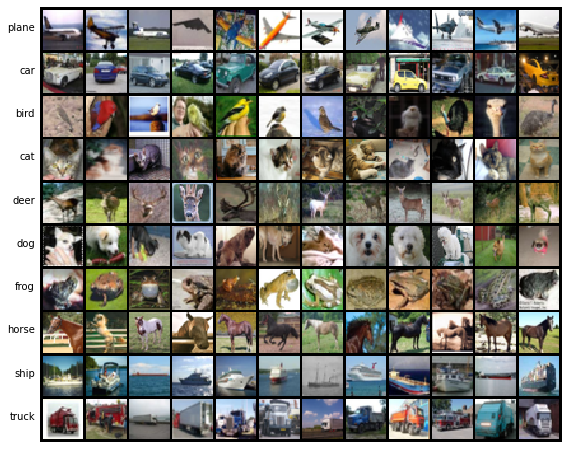

Train data shape:  torch.Size([49000, 3073])
Train labels shape:  torch.Size([49000])
Validation data shape:  torch.Size([1000, 3073])
Validation labels shape:  torch.Size([1000])
Test data shape:  torch.Size([10000, 3073])
Test labels shape:  torch.Size([10000])


In [ ]:
def get_CIFAR10_data(validation_ratio = 0.02):
  """
  Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
  it for the linear classifier.
  """
  X_train, y_train, X_test, y_test = coutils.data.cifar10()

  # Move all the data to the GPU
  X_train = X_train.cuda()
  y_train = y_train.cuda()
  X_test = X_test.cuda()
  y_test = y_test.cuda()

  # 0. Visualize some examples from the dataset.
  class_names = [
      'plane', 'car', 'bird', 'cat', 'deer',
      'dog', 'frog', 'horse', 'ship', 'truck'
  ]
  img = coutils.utils.visualize_dataset(X_train, y_train, 12, class_names)
  plt.imshow(img)
  plt.axis('off')
  plt.show()

  # 1. Normalize the data: subtract the mean RGB (zero mean)
  mean_image = X_train.mean(dim=0, keepdim=True).mean(dim=2, keepdim=True).mean(dim=3, keepdim=True)
  X_train -= mean_image
  X_test -= mean_image

  # 2. Reshape the image data into rows
  X_train = X_train.reshape(X_train.shape[0], -1)
  X_test = X_test.reshape(X_test.shape[0], -1)

  # 3. Add bias dimension and transform into columns
  ones_train = torch.ones(X_train.shape[0], 1, device=X_train.device)
  X_train = torch.cat([X_train, ones_train], dim=1)
  ones_test = torch.ones(X_test.shape[0], 1, device=X_test.device)
  X_test = torch.cat([X_test, ones_test], dim=1)

  # 4. Carve out part of the training set to use for validation.
  # For random permutation, you can use torch.randperm or torch.randint
  # But, for this homework, we use slicing instead.
  num_training = int( X_train.shape[0] * (1.0 - validation_ratio) )
  num_validation = X_train.shape[0] - num_training

  # Return the dataset as a dictionary
  data_dict = {}
  data_dict['X_val'] = X_train[num_training:num_training + num_validation]
  data_dict['y_val'] = y_train[num_training:num_training + num_validation]
  data_dict['X_train'] = X_train[0:num_training]
  data_dict['y_train'] = y_train[0:num_training]

  data_dict['X_test'] = X_test
  data_dict['y_test'] = y_test
  return data_dict

# Invoke the above function to get our data.
data_dict = get_CIFAR10_data()
print('Train data shape: ', data_dict['X_train'].shape)
print('Train labels shape: ', data_dict['y_train'].shape)
print('Validation data shape: ', data_dict['X_val'].shape)
print('Validation labels shape: ', data_dict['y_val'].shape)
print('Test data shape: ', data_dict['X_test'].shape)
print('Test labels shape: ', data_dict['y_test'].shape)

We will use the following function to check our gradient implementations.

In [ ]:
def grad_check_sparse(f, x, analytic_grad, num_checks=10, h=1e-7):
  """
  Utility function to perform numeric gradient checking. We use the centered
  difference formula to compute a numeric derivative:
  
  f'(x) =~ (f(x + h) - f(x - h)) / (2h)

  Rather than computing a full numeric gradient, we sparsely sample a few
  dimensions along which to compute numeric derivatives.

  Inputs:
  - f: A function that inputs a torch tensor and returns a torch scalar
  - x: A torch tensor giving the point at which to evaluate the numeric gradient
  - analytic_grad: A torch tensor giving the analytic gradient of f at x
  - num_checks: The number of dimensions along which to check
  - h: Step size for computing numeric derivatives
  """
  # fix random seed for 
  coutils.utils.fix_random_seed()

  for i in range(num_checks):
    
    ix = tuple([random.randrange(m) for m in x.shape])
    
    oldval = x[ix].item()
    x[ix] = oldval + h # increment by h
    fxph = f(x).item() # evaluate f(x + h)
    x[ix] = oldval - h # increment by h
    fxmh = f(x).item() # evaluate f(x - h)
    x[ix] = oldval     # reset

    grad_numerical = (fxph - fxmh) / (2 * h)
    grad_analytic = analytic_grad[ix]
    rel_error_top = abs(grad_numerical - grad_analytic)
    rel_error_bot = (abs(grad_numerical) + abs(grad_analytic) + 1e-12)
    rel_error = rel_error_top / rel_error_bot
    msg = 'numerical: %f analytic: %f, relative error: %e'
    print(msg % (grad_numerical, grad_analytic, rel_error))

## Linear Classifier with Softmax

In this section, you will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights

For our linear classifier, we use a simple linear mapping followed by a softmax operation to predict the probability distribution over the different classes. We then use the cross-entropy loss to compare our prediction to the given ground truth label.

Assume we are given a training dataset of images $x^{(i)} \in R^D$, each with an associated class label $y^{(i)}$. Here $i=1...N$ and $y_i \in 1...K$ where $N$ is the total number of training examples and $K$ is the total number of classes. For our CIFAR10 dataset, we have $N=49000$, $K=10$, and $D=(32x32x3) + 1 = 3073$.

The linear classifier multiples the input $x^{(i)}$ with a single parameter matrix $W \in R^{DxK}$ to predict the probability distribution over classes:

$$ o^{(i)} = W^T x^{(i)} $$
$$ \hat{y}^{(i)} = \text{softmax}(o^{(i)}) $$

where the $j$-th entry of $\hat{y}^{(i)}$ is given by

$$ \hat{y}^{(i)}_j = \frac{\exp(o^{(i)}_j)}{\sum_k \exp(o^{(i)}_k)} $$  

The intermediate values $o^{(i)}$ are the unnormalized log probabilities of the different classes and are commonly referred to as "logits". The softmax operation, which we saw in the previous assignment, is used to normalize the logits to a proper probability distribution.

We then use the cross-entropy loss to compare the prediction to the ground truth label. Let us first define $p^{(i)}$ to be the ground truth probability distribution of the class. This just means that $p^{(i)}$ is a one-hot vector with a 1 in the $y^{(i)}$-th position and zeros everywhere else. Then, from the definition of cross-entropy we saw in class, we have the following loss for the $i$-th training example:

\begin{align}
L^{(i)} &= -\sum_j p^{(i)}_j \log \hat{y}^{(i)}_j \\
&= - \log \hat{y}^{(i)}_{y^{(i)}} \\
&= - \log \frac{\exp(o^{(i)}_{y^{(i)}})}{\sum_k \exp(o^{(i)}_k)} \\
\end{align}

The second equality holds because $p^{(i)}$ has zeros everywhere except position $y^{(i)}$, so we only need to keep the $y^{(i)}$-th position of $\hat{y}^{(i)}$. Averaging over all the training examples and adding an L2-regularization term, we have the following loss:

$$ L = \frac{1}{N} \sum_i L^{(i)} + \lambda \sum_k \sum_l W_{k,l}^2 $$

Where $\lambda$ is a hyperparameter. Note that for simplicity we do not divide $\lambda$ by 2 here.


First, let's start from implementing the naive softmax cross-entropy loss function described above using nested loops. Your solution should have one loop going through all the training examples and more loops going through the number of classes. Your function should return both $L$ and $dL/dW$, the gradient of $L$ with respect to $W$.

In [ ]:
def softmax_loss_naive(W, X, y, reg): 
  """
  Softmax loss function, naive implementation (with loops).  When you implement 
  the regularization over W, please DO NOT multiply the regularization term by 
  1/2 (no coefficient). 

  Inputs have dimension D, there are K classes, and we operate on minibatches
  of N examples.

  Inputs:
  - W: A PyTorch tensor of shape (D, K) containing weights.
  - X: A PyTorch tensor of shape (N, D) containing a minibatch of data.
  - y: A PyTorch tensor of shape (N,) containing the ground truth training labels; y[i] = k means
    that X[i] has label k, where 0 <= k < K.
  - reg: (float) regularization strength

  Returns a tuple of:
  - loss as single float
  - gradient with respect to weights W; an tensor of same shape as W
  """
  # Initialize the loss and gradient to zero.
  loss = 0.0
  dW = torch.zeros_like(W)

  #############################################################################
  # TODO: Compute the softmax loss and its gradient using explicit loops.     #
  # Store the loss in loss and the gradient in dW. If you are not careful     #
  # here, it is easy to run into numeric instability. Don't forget the        #
  # regularization!                                                           #
  #############################################################################
  # Replace "pass" statement with your code
  num_train = X.shape[0]
  num_classes = W.shape[1]

  for i in range(num_train):

    logits = torch.matmul(X[i], W)

    # correct_logits = logits[y[i]]  #

    sum_exp = torch.sum(torch.exp(logits))
    probs = lambda k: torch.exp(logits[k]) / sum_exp
    loss -= torch.log(probs(y[i]))

    for k in range(num_classes):
      probs_k = probs(k)
      if y[i] == k:
        dW[:, k] +=  (probs_k - 1) * X[i]
      else:
        dW[:, k] +=  (probs_k) * X[i]
     

  loss /= num_train
  loss += reg * torch.sum(W * W)
  
  dW /= num_train
  dW += 2*reg*W # must multiply by 2 because "Note that for simplicity we do not divide  𝜆  by 2 here."

  # END OF YOUR CODE

  return loss, dW

As a sanity check to see whether we have implemented the loss correctly, run the softmax classifier with a small random weight matrix and no regularization. You should see loss near log(10) = 2.3

In [ ]:
# Generate a random softmax weight tensor and use it to compute the loss.
coutils.utils.fix_random_seed()
W = 0.0001 * torch.randn(3073, 10, device=data_dict['X_val'].device).double()

X_batch = data_dict['X_val'][:128].double()
y_batch = data_dict['y_val'][:128]

# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_batch, y_batch, reg=0.0)

# As a rough sanity check, our loss should be something close to log(10.0).
print('loss: %f' % loss)
print('sanity check: %f' % (math.log(10.0)))

loss: 2.302600
sanity check: 2.302585


Next, we use gradient checking to debug the analytic gradient of our naive softmax loss function. If you've implemented the gradient correctly, you should see relative errors less than `1e-5`.


In [ ]:
coutils.utils.fix_random_seed()
W = 0.0001 * torch.randn(3073, 10, device=data_dict['X_val'].device).double()
X_batch = data_dict['X_val'][:128].double()
y_batch = data_dict['y_val'][:128]

loss, grad = softmax_loss_naive(W, X_batch, y_batch, reg=0.0)

f = lambda w: softmax_loss_naive(w, X_batch, y_batch, reg=0.0)[0]
grad_check_sparse(f, W, grad, 10)

numerical: 0.008387 analytic: 0.008387, relative error: 4.265750e-09
numerical: 0.009227 analytic: 0.009227, relative error: 4.675595e-07
numerical: -0.002471 analytic: -0.002471, relative error: 1.625583e-06
numerical: -0.003144 analytic: -0.003144, relative error: 9.907012e-07
numerical: 0.006011 analytic: 0.006011, relative error: 4.860090e-07
numerical: 0.005936 analytic: 0.005936, relative error: 5.008406e-07
numerical: 0.015703 analytic: 0.015703, relative error: 1.198765e-07
numerical: 0.006452 analytic: 0.006452, relative error: 2.162977e-09
numerical: -0.015533 analytic: -0.015533, relative error: 4.257914e-08
numerical: -0.010170 analytic: -0.010170, relative error: 1.383112e-07


Let's perform another gradient check with regularization enabled. Again you should see relative errors less than `1e-5`.

In [ ]:
coutils.utils.fix_random_seed()
W = 0.0001 * torch.randn(3073, 10, device=data_dict['X_val'].device).double()
reg = 10.0

X_batch = data_dict['X_val'][:128].double()
y_batch = data_dict['y_val'][:128]

loss, grad = softmax_loss_naive(W, X_batch, y_batch, reg)

f = lambda w: softmax_loss_naive(w, X_batch, y_batch, reg)[0]
grad_check_sparse(f, W, grad, 10)

numerical: 0.007517 analytic: 0.007517, relative error: 8.089159e-08
numerical: 0.008167 analytic: 0.008167, relative error: 5.558064e-07
numerical: -0.002551 analytic: -0.002551, relative error: 1.432175e-06
numerical: -0.000841 analytic: -0.000841, relative error: 3.693301e-06
numerical: 0.002228 analytic: 0.002228, relative error: 1.088308e-06
numerical: 0.005460 analytic: 0.005460, relative error: 4.646146e-07
numerical: 0.015762 analytic: 0.015762, relative error: 1.405207e-07
numerical: 0.007097 analytic: 0.007097, relative error: 9.105653e-09
numerical: -0.015532 analytic: -0.015532, relative error: 7.197051e-08
numerical: -0.011201 analytic: -0.011201, relative error: 1.249997e-07


Our implementation above is fairly inefficient since it uses nested Python loops over the training set.

When implementing algorithms in PyTorch, it's best to avoid loops in Python if possible. Instead it is preferable to implement your computation so that all loops happen inside PyTorch functions. This will usually be much faster than writing your own loops in Python, since PyTorch functions can be internally optimized to iterate efficiently, possibly using multiple threads. This is especially important when using a GPU to accelerate your code.

The process of eliminating explict loops from your code is called vectorization. Sometimes it is straighforward to vectorize code originally written with loops; other times vectorizing requires thinking about the problem in a new way. We will use vectorization to improve the speed of our distance computation function.

Now let's implement a vectorized form of our softmax cross-entropy loss function. The two versions should compute the same results, but the vectorized version should be much faster.

In [ ]:
def softmax_loss_vectorized(W, X, y, reg):
  """
  Softmax loss function, vectorized version.  When you implement the 
  regularization over W, please DO NOT multiply the regularization term by 1/2 
  (no coefficient). 

  Inputs and outputs are the same as softmax_loss_naive.
  """
  # Initialize the loss and gradient to zero.
  loss = 0.0
  dW = torch.zeros_like(W)

  #############################################################################
  # TODO: Compute the softmax loss and its gradient using no explicit loops.  #
  # Store the loss in loss and the gradient in dW. Don't forget the           #
  # regularization!                                                           #
  #############################################################################
  # Replace "pass" statement with your code
  num_train = X.shape[0]
  num_classes = W.shape[1]
  
  # SOFTMAX
  logits = torch.matmul(X, W)
  probs = torch.exp(logits) / torch.sum(torch.exp(logits), dim = 1).view(-1, 1)
  # print(probs)
  # LOSS ENTROPY
  log_probs = -torch.log(probs[range(num_train), y])

  data_loss = torch.sum(log_probs) / num_train
  reg_loss = reg * torch.sum(W*W)

  loss = data_loss + reg_loss

  # GRADIENT
  d_probs = probs
  d_probs[range(num_train), y] -= 1

  dW = torch.matmul(X.T, d_probs)
  dW /= num_train
  dW += 2*reg*W
  # END OF YOUR CODE
  
  return loss, dW

The differences between the naive and vectorized losses and gradients should both be less than `1e-6`, and your vectorized implementation should be at least 100x faster than the naive implementation.

In [ ]:
coutils.utils.fix_random_seed()
W = 0.0001 * torch.randn(3073, 10, device=data_dict['X_val'].device)
reg = 0.05

X_batch = data_dict['X_val'][:128]
y_batch = data_dict['y_val'][:128]

# Run and time the naive version
torch.cuda.synchronize()
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_batch, y_batch, reg)
torch.cuda.synchronize()
toc = time.time()
ms_naive = 1000.0 * (toc - tic)
print('naive loss: %e computed in %fs' % (loss_naive, ms_naive))

# Run and time the vectorized version
torch.cuda.synchronize()
tic = time.time()
loss_vec, grad_vec = softmax_loss_vectorized(W, X_batch, y_batch, reg)
torch.cuda.synchronize()
toc = time.time()
ms_vec = 1000.0 * (toc - tic)
print('vectorized loss: %e computed in %fs' % (loss_vec, ms_vec))

# we use the Frobenius norm to compare the two versions of the gradient.
loss_diff = (loss_naive - loss_vec).abs().item()
grad_diff = torch.norm(grad_naive - grad_vec, p='fro')
print('Loss difference: %.2e' % loss_diff)
print('Gradient difference: %.2e' % grad_diff)
print('Speedup: %.2fX' % (ms_naive / ms_vec))
print('Loss vec is: ', loss_vec.item())
print('Loss naive is: ', loss_naive.item())

naive loss: 2.302615e+00 computed in 264.112949s
vectorized loss: 2.302616e+00 computed in 4.256725s
Loss difference: 4.77e-07
Gradient difference: 3.15e-07
Speedup: 62.05X
Loss vec is:  2.3026156425476074
Loss naive is:  2.302615165710449


Now that we have an efficient vectorized implementation of the softmax cross-entropy loss and its gradient, we can implement a training pipeline for linear classifiers.

Complete the implementation of the following function:


In [ ]:
def train_linear_classifier(loss_func, W, X, y, learning_rate=1e-3, 
                            reg=1e-5, num_iters=100, batch_size=200, verbose=False):
  """
  Train this linear classifier using stochastic gradient descent.

  Inputs:
  - loss_func: loss function to use when training. It should take W, X, y
    and reg as input, and output a tuple of (loss, dW)
  - W: A PyTorch tensor of shape (D, K) giving the initial weights of the
    classifier. If W is None then it will be initialized here.
  - X: A PyTorch tensor of shape (N, D) containing training data; there are N
    training samples each of dimension D.
  - y: A PyTorch tensor of shape (N,) containing training labels; y[i] = k
    means that X[i] has label 0 <= k < K for K classes.
  - learning_rate: (float) learning rate for optimization.
  - reg: (float) regularization strength.
  - num_iters: (integer) number of steps to take when optimizing
  - batch_size: (integer) number of training examples to use at each step.
  - verbose: (boolean) If true, print progress during optimization.

  Returns: A tuple of:
  - W: The final value of the weight matrix and the end of optimization
  - loss_history: A list of Python scalars giving the values of the loss at each
    training iteration.
  """
  # assume y takes values 0...K-1 where K is number of classes
  num_train, dim = X.shape
  if W is None:
    # lazily initialize W
    num_classes = torch.max(y) + 1
    W = 0.000001 * torch.randn(dim, num_classes, device=X.device, dtype=X.dtype)
  else:
    num_classes = W.shape[1]
  # Run stochastic gradient descent to optimize W
  loss_history = []
  for it in range(num_iters):
    X_batch = None
    y_batch = None
    #########################################################################
    # TODO:                                                                 #
    # Sample batch_size elements from the training data and their           #
    # corresponding labels to use in this round of gradient descent.        #
    # Store the data in X_batch and their corresponding labels in           #
    # y_batch; after sampling, X_batch should have shape (batch_size, dim)  #
    # and y_batch should have shape (batch_size,)                           #
    #                                                                       #
    # Hint: Use torch.randint to generate indices.                          #
    #########################################################################
    # Replace "pass" statement with your code
    random_sample_idx = torch.randint(num_train, (batch_size,))
    X_batch = X[random_sample_idx, :]
    y_batch = y[random_sample_idx]
    # END OF YOUR CODE

    # evaluate loss and gradient
    loss, grad = loss_func(W, X_batch, y_batch, reg)
    loss_history.append(loss.item())

    # perform parameter update
    #########################################################################
    # TODO:                                                                 #
    # Update the weights using the gradient and the learning rate.          #
    #########################################################################
    # Replace "pass" statement with your code
    W -= learning_rate*grad
    # END OF YOUR CODE

    if verbose and it % 100 == 0:
      print('iteration %d / %d: loss %f' % (it, num_iters, loss))

  return W, loss_history

Let's check that your implementation of the softmax loss is numerically stable.

If either of the following print nan then you should double-check the numeric stability of your implementations.

In [ ]:
device = data_dict['X_train'].device
dtype = torch.float32
D = data_dict['X_train'].shape[1]
C = 10

W_ones = torch.ones(D, C, device=device, dtype=dtype)
W, loss_hist = train_linear_classifier(softmax_loss_naive, W_ones, 
                                       data_dict['X_train'], 
                                       data_dict['y_train'], 
                                       learning_rate=1e-8, reg=2.5e4,
                                       num_iters=1, verbose=True)


W_ones = torch.ones(D, C, device=device, dtype=dtype)
W, loss_hist = train_linear_classifier(softmax_loss_vectorized, W_ones, 
                                       data_dict['X_train'], 
                                       data_dict['y_train'], 
                                       learning_rate=1e-8, reg=2.5e4,
                                       num_iters=1, verbose=True)


iteration 0 / 1: loss nan
iteration 0 / 1: loss nan


Now lets train a softmax classifier with some default hyperparameters:


In [ ]:
# fix random seed before we perform this operation
coutils.utils.fix_random_seed(10)

torch.cuda.synchronize()
tic = time.time()

W, loss_hist = train_linear_classifier(softmax_loss_vectorized, None, 
                                       data_dict['X_train'], 
                                       data_dict['y_train'], 
                                       learning_rate=1e-10, reg=2.5e4,
                                       num_iters=1500, verbose=True)

torch.cuda.synchronize()
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 2.303346
iteration 100 / 1500: loss 2.303344
iteration 200 / 1500: loss 2.303344
iteration 300 / 1500: loss 2.303342
iteration 400 / 1500: loss 2.303342
iteration 500 / 1500: loss 2.303342
iteration 600 / 1500: loss 2.303342
iteration 700 / 1500: loss 2.303341
iteration 800 / 1500: loss 2.303338
iteration 900 / 1500: loss 2.303339
iteration 1000 / 1500: loss 2.303339
iteration 1100 / 1500: loss 2.303336
iteration 1200 / 1500: loss 2.303335
iteration 1300 / 1500: loss 2.303337
iteration 1400 / 1500: loss 2.303334
That took 1.667507s


Plot the loss curve:

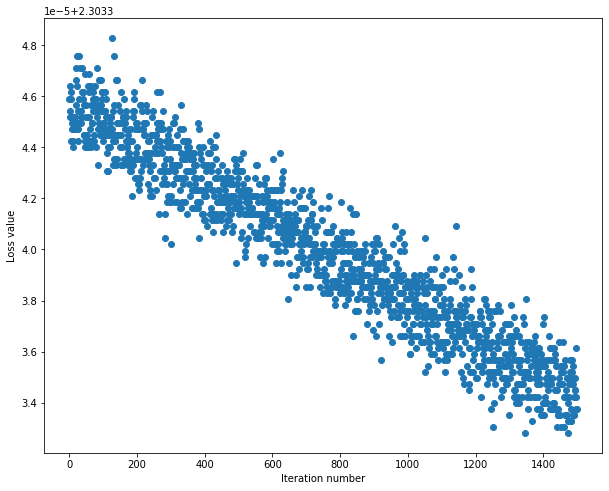

In [ ]:
plt.plot(loss_hist, 'o')
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

Let's move on to the prediction stage:

In [ ]:
def predict_linear_classifier(W, X):
  """
  Use the trained weights of this linear classifier to predict labels for
  data points.

  Inputs:
  - W: A PyTorch tensor of shape (D, C), containing weights of a model
  - X: A PyTorch tensor of shape (N, D) containing training data; there are N
    training samples each of dimension D.

  Returns:
  - y_pred: PyTorch int64 tensor of shape (N,) giving predicted labels for each
    elemment of X. Each element of y_pred should be between 0 and C - 1.
  """
  y_pred = torch.zeros(X.shape[0])
  ###########################################################################
  # TODO:                                                                   #
  # Implement this method. Store the predicted labels in y_pred.            #
  ###########################################################################
  # Replace "pass" statement with your code
  probs = torch.matmul(X, W)
  y_pred = torch.argmax(probs, axis=-1)
  # END OF YOUR CODE
  return y_pred

Then, let's evaluate the performance our trained model on both the training and validation set. You should see validation accuracy less than 10%.

In [ ]:
# evaluate the performance on both the training and validation set
y_train_pred = predict_linear_classifier(W, data_dict['X_train'])
train_acc = 100.0 * (data_dict['y_train'] == y_train_pred).float().mean().item()
print('training accuracy: %.2f%%' % train_acc)
y_val_pred = predict_linear_classifier(W, data_dict['X_val'])
val_acc = 100.0 * (data_dict['y_val'] == y_val_pred).float().mean().item()
print('validation accuracy: %.2f%%' % val_acc)

training accuracy: 8.43%
validation accuracy: 8.00%


Unfortunately, the performance of our initial model is quite bad. To find a better hyperparamters, let's first modulize the functions that we've implemented.

In [ ]:
class LinearClassifier(object):
  
  def __init__(self):
    self.W = None
    
  def train(self, X_train, y_train, learning_rate=1e-3, reg=1e-5, num_iters=100,
            batch_size=200, verbose=False):
    train_args = (self.loss, self.W, X_train, y_train, learning_rate, reg,
                  num_iters, batch_size, verbose)
    self.W, loss_history = train_linear_classifier(*train_args)
    return loss_history

  def predict(self, X):
    return predict_linear_classifier(self.W, X) 
  
  def loss(self, W, X_batch, y_batch, reg):
    """
    Compute the loss function and its derivative. 
    Subclasses will override this.

    Inputs:
    - W: A PyTorch tensor of shape (D, C) containing (trained) weight of a model.
    - X_batch: A PyTorch tensor of shape (N, D) containing a minibatch of N
      data points; each point has dimension D.
    - y_batch: A PyTorch tensor of shape (N,) containing labels for the minibatch.
    - reg: (float) regularization strength.

    Returns: A tuple containing:
    - loss as a single float
    - gradient with respect to self.W; an tensor of the same shape as W
    """
    pass
  def _loss(self, X_batch, y_batch, reg):
    self.loss(self.W, X_batch, y_batch, reg)

  
class Softmax(LinearClassifier):
  """ A subclass that uses the Softmax + Cross-entropy loss function """
  def loss(self, W, X_batch, y_batch, reg):
    return softmax_loss_vectorized(W, X_batch, y_batch, reg)


Now, please use the validation set to tune hyperparameters (regularization strength and learning rate). You should experiment with different ranges for the learning rates and regularization strengths.

To get full credit for the assignment your best model found through cross-validation should achieve an accuracy of at least 37% on the validation set.


In [ ]:
results = {}
best_val = -1
best_softmax = None

learning_rates = [] # learning rate candidates
regularization_strengths = [] # regularization strengths candidates

# As before, store your cross-validation results in this dictionary.
# The keys should be tuples of (learning_rate, regularization_strength) and
# the values should be tuples (train_accuracy, val_accuracy)
results = {}

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# Save your best trained softmax classifer in best_softmax.                    # 
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a softmax classifier on  #
# the training set, compute its accuracy on the training and validation sets,  #
# and store these numbers in the results dictionary. In addition, store the    # 
# best validation accuracy in best_val and the Softmax object that achieves    #
# this accuracy in best_softmax.                                              #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the classifiers don't take much time to train;       #
# once you are confident that your validation code works, you should rerun the #
# validation code with a larger value for num_iters.                           #
################################################################################
# Replace "pass" statement with your code

X_train = data_dict['X_train']
y_train = data_dict['y_train']
X_val = data_dict['X_val']
y_val = data_dict['y_val']

learning_rates = [1e-2, 1e-3, 1e-4, 1e-5, 2e-7, 1e-7, 1e-8, 1e-9, 1e-10]
regularization_strengths = [1e-5, 2.5e3, 2.5e-4, 1e-7, 2.5e3, 2e4, 2.5e4, 2e2, 2.3e5, 1e9]
 
iters = 1900
for lr in learning_rates:
    for rs in regularization_strengths:
        softmax = Softmax()
        softmax.train(X_train, y_train, learning_rate=lr, reg=rs, num_iters=iters)
        
        y_train_pred = softmax.predict(X_train)
        # y_temp_train = torch.tensor(y_train == y_train_pred).to(torch.float32)
        # y_temp_val = torch.tensor(y_val == y_val_pred).to(torch.float32)
        # print(y_temp_train)
        acc_train = torch.mean((y_train == y_train_pred).float())
        y_val_pred = softmax.predict(X_val)
        acc_val = torch.mean((y_val == y_val_pred).float())
        
        results[(lr, rs)] = (acc_train, acc_val)
        
        if best_val < acc_val:
            best_val = acc_val
            best_softmax = softmax

# END OF YOUR CODE
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 1.000000e-10 reg 1.000000e-07 train accuracy: 0.105653 val accuracy: 0.111000
lr 1.000000e-10 reg 1.000000e-05 train accuracy: 0.105102 val accuracy: 0.097000
lr 1.000000e-10 reg 2.500000e-04 train accuracy: 0.080959 val accuracy: 0.073000
lr 1.000000e-10 reg 2.000000e+02 train accuracy: 0.113653 val accuracy: 0.107000
lr 1.000000e-10 reg 2.500000e+03 train accuracy: 0.113347 val accuracy: 0.103000
lr 1.000000e-10 reg 2.000000e+04 train accuracy: 0.103000 val accuracy: 0.105000
lr 1.000000e-10 reg 2.500000e+04 train accuracy: 0.113490 val accuracy: 0.113000
lr 1.000000e-10 reg 2.300000e+05 train accuracy: 0.130061 val accuracy: 0.131000
lr 1.000000e-10 reg 1.000000e+09 train accuracy: 0.244102 val accuracy: 0.236000
lr 1.000000e-09 reg 1.000000e-07 train accuracy: 0.108816 val accuracy: 0.114000
lr 1.000000e-09 reg 1.000000e-05 train accuracy: 0.105224 val accuracy: 0.075000
lr 1.000000e-09 reg 2.500000e-04 train accuracy: 0.138694 val accuracy: 0.143000
lr 1.000000e-09 reg 2.000000

Run the following to visualize your cross-validation results:

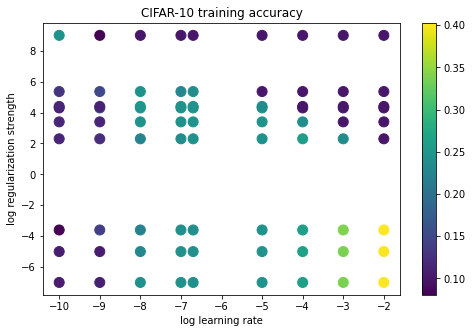

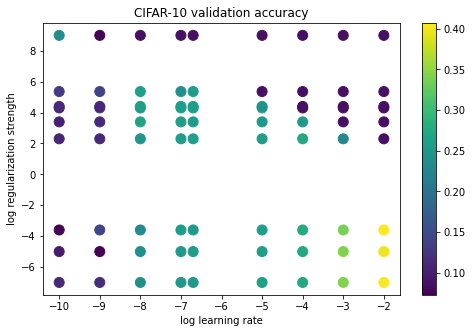

In [ ]:
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap='viridis')
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')
plt.gcf().set_size_inches(8, 5)
plt.show()

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap='viridis')
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.gcf().set_size_inches(8, 5)
plt.show()

Them, evaluate the performance of your best model on test set. To get full credit for this assignment you should achieve a test-set accuracy above 0.36.


In [ ]:
y_test_pred = best_softmax.predict(data_dict['X_test'])
test_accuracy = torch.mean((data_dict['y_test'] == y_test_pred).float())
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.396100


Finally, let's visualize the learned weights for each class

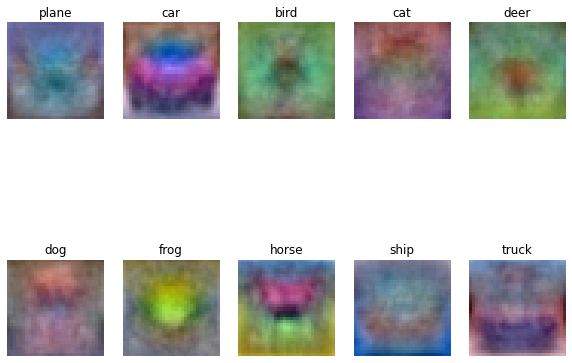

In [ ]:
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(3, 32, 32, 10)
w = w.transpose(0, 2).transpose(1, 0)

w_min, w_max = torch.min(w), torch.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
  plt.subplot(2, 5, i + 1)

  # Rescale the weights to be between 0 and 255
  wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
  plt.imshow(wimg.type(torch.uint8).cpu())
  plt.axis('off')
  plt.title(classes[i])